<a href="https://colab.research.google.com/github/Astromax/Retina_Disease_Classification/blob/main/EyeDiseaseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this is to determine whether or not a retina is healthy, and, if not, which of six different diseases it has. The data for this comes from a Kaggle competition, https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview.
 There are 3,435 training images, with the following label breakdown: opacity - 0, diabetic retinopathy - 1, glaucoma - 2, macular edema - 3, macular degeneration - 4, retinal vascular occlusion - 5, and normal - 6.
An important note: unlike an ordinary classification problem, in this case a retina may be afflicted with more than one ailment.  Because of this, the activation function for the final layer is sigmoid, instead of the usual softmax, effectively providing a probability for each label independent of the others.

The data has been uploaded to my Google Drive for easy access & processing, if anyone reading this wants to replicate it just change the target directories.

In [ ]:
#First let's mount the Drive so we can access the data...
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/EyeDiseaseDetection/')
MAIN_DIR = '/content/drive/MyDrive/EyeDiseaseDetection'

In [ ]:
#from resnet_module_helpers_tf import *
from eye_DD_metrics_helpers import *
#from training_plot_helpers import *

# Display
from IPython.display import Image, display

import json

import matplotlib.cm as colormap
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
from PIL import Image, ImageDraw
from plotly.subplots import make_subplots

import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix as MLCM
from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.activations import relu, swish
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop, RandomFlip, RandomRotation

import time
from tqdm import tqdm

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
#Establish location of data
data_dir = './Data/Data/train'
image_dir = data_dir+'/train'

In [ ]:
filenames = os.listdir(image_dir)
print(f'Number of files: {len(filenames)}')

Number of files: 3435


In [ ]:
#index_map is in this cell because we need it in multiple places & this cell always runs
index_map = {0: 'Opacity', 1: 'Diabetic Retinopathy', 2: 'Glaucoma', 3: 'Macular Edema', 4: 'Macular Degeneration', 
             5: 'Retinal Vascular Occlusion', 6: 'Normal'}

labels_df = pd.read_csv(data_dir+'/train.csv')

## Exploratory Data Analysis

Before doing the heavy-duty analysis, let's first make sure there are no anomalies.  A retina can have multiple diseases simultaneously, which means this is not a simple image classification problem.  However, there is also a seventh label, 'Normal', corresponding to a healthy retina.  If a retina has a disease it is, by definition, unhealthy, therefore any images with a one in the 'Normal' column *and any other* is an anomaly, which should be excluded from the analysis.  Similarly, an image with all zeros, corresponding to either a mislabel or a retina with a disease not in this set, is not useful for this analysis.

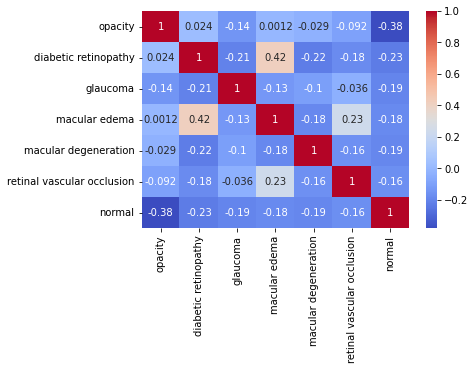

In [ ]:
#Let's get the correlations between all pairs of columns and plot them as a heatmap
fig = sns.heatmap(labels_df.corr(), annot=True, fmt='0.2g', cmap='coolwarm')
fig.figure.savefig(f'{MAIN_DIR}/Disease_Correlations.png')

We see there is some correlation between diabetic retinopathy and macular edema, and a more mild correlation between macular edema and retinal vascular occlusion.  Normality is anti-correlated with all other labels, which is to be expected, although the magnitude is not as great as I would have expected.  Diabetic retinopathy is anti-correlated with glaucoma and macular degeneration.  More domain knowledge is necessary to interpret these (anti)correlations, but they are interesting nonetheless.

To streamline the process of entering in the labels for training, we first create a new column consolidating the entries in the seven main columns into a column of 7-tuples.  This is the "y" that the model is learning from and trying to predict.

In [ ]:
#Convert the individual label values to int type, add in a multi-hot vector label
MH = list(zip(labels_df['opacity'], labels_df['diabetic retinopathy'], labels_df['glaucoma'], labels_df['macular edema'],
                                  labels_df['macular degeneration'], labels_df['retinal vascular occlusion'], labels_df['normal']))
labels_df['Multi_Hot'] = MH

In [ ]:
y = labels_df['Multi_Hot']
y = np.array([y.iloc[i] for i in range(len(y))])
print(f'Length of y: {len(y)}')

Length of y: 3435


In [ ]:
#More efficient anomaly check
blanks = [p for p in y if sum(p) == 0]
print(f'Number of Blanks: {len(blanks)}')

anomalies = [p for p in y if p[-1] == 1 and sum(p[:-1]) > 0]
print(f'Number of Anomalies: {len(anomalies)}')

Number of Blanks: 0
Number of Anomalies: 0


In [ ]:
# Copied & modified from: https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
def addlabels(x,y):
    for idx,_ in enumerate(x):
        plt.text(idx, y[idx], y[idx], ha = 'center',
                 Bbox = dict(facecolor = 'red', alpha =.8))

Number of Totals: 2910


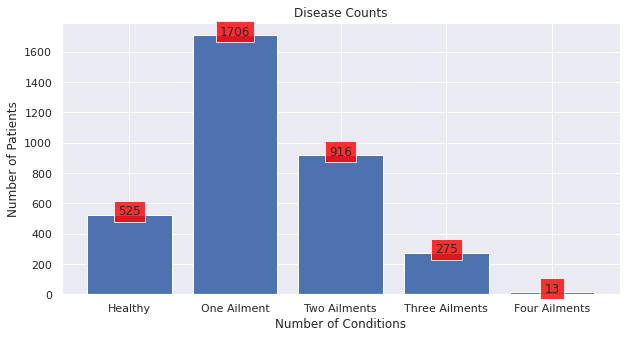

In [ ]:
#Let's see how many patients have one vs two vs ... ailments
totals = [sum(p) for idx,p in enumerate(y) if p[-1] != 1]
print(f'Number of Totals: {len(totals)}')

hs  = [p for p in y if p[-1] == 1]
p1s = [p for p in totals if p == 1]
p2s = [p for p in totals if p == 2]
p3s = [p for p in totals if p == 3]
p4s = [p for p in totals if p == 4]

x = ['Healthy', 'One Ailment', 'Two Ailments', 'Three Ailments', 'Four Ailments']
z = [len(hs), len(p1s), len(p2s), len(p3s), len(p4s)]

fname = f'{MAIN_DIR}/Disease_Counts.jpg'
plt.figure(figsize=(10,5))
plt.bar(x, z)
addlabels(x, z)
plt.title('Disease Counts')
plt.xlabel('Number of Conditions')
plt.ylabel('Number of Patients')
plt.savefig(fname)
plt.show()

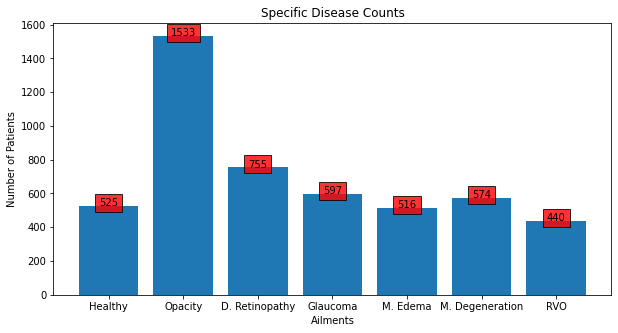

In [ ]:
#Plot the individual number of occurrences for each ailment

hs  = [p for p in y if p[-1] == 1]
p_opa = [p for p in y if p[0] == 1]
p_dr = [p for p in y if p[1] == 1]
p_gla = [p for p in y if p[2] == 1]
p_me = [p for p in y if p[3] == 1]
p_md = [p for p in y if p[4] == 1]
p_rvo = [p for p in y if p[5] == 1]

x = ['Healthy', 'Opacity', 'D. Retinopathy', 'Glaucoma', 'M. Edema', 'M. Degeneration', 'RVO']
z = [len(hs), len(p_opa), len(p_dr), len(p_gla), len(p_me), len(p_md), len(p_rvo)]

fname = f'{MAIN_DIR}/Individual_Disease_Counts.jpg'
plt.figure(figsize=(10,5))
plt.bar(x, z)
addlabels(x, z)
plt.title('Specific Disease Counts')
plt.xlabel('Ailments')
plt.ylabel('Number of Patients')
plt.xticks(fontsize=10)
plt.savefig(fname)
plt.show()

In [ ]:
#Let's have a look specifically at the 13 unfortunate souls with 4 separate conditions
souls = [dg for dg in y if sum(dg) == 4]
for s in souls:
    print(f'Conditions: {s}')

opcount = len([1 for s in souls if s[0] == 1])
drcount = len([1 for s in souls if s[1] == 1])
glcount = len([1 for s in souls if s[2] == 1])
mecount = len([1 for s in souls if s[3] == 1])
mdcount = len([1 for s in souls if s[4] == 1])
rvcount = len([1 for s in souls if s[5] == 1])

print(f'Opacity: {opcount}')
print(f'DR: {drcount}')
print(f'Glaucoma: {glcount}')
print(f'MacEd: {mecount}')
print(f'MacDeg: {mdcount}')
print(f'RVO: {rvcount}')

Conditions: [1 1 0 1 1 0 0]
Conditions: [1 1 0 1 1 0 0]
Conditions: [1 0 1 1 0 1 0]
Conditions: [1 0 1 1 0 1 0]
Conditions: [1 0 1 1 0 1 0]
Conditions: [1 0 1 1 0 1 0]
Conditions: [1 0 1 1 0 1 0]
Conditions: [1 0 1 1 0 1 0]
Conditions: [1 1 0 1 0 1 0]
Conditions: [1 1 0 1 0 1 0]
Conditions: [1 0 1 1 0 1 0]
Conditions: [1 0 1 1 0 1 0]
Conditions: [1 1 1 1 0 0 0]
Opacity: 13
DR: 5
Glaucoma: 9
MacEd: 13
MacDeg: 2
RVO: 10


Here we load in the full set of images.  tqdm produces the progress bar and is not strictly necessary, but with this many images it can be nice to know how much longer to expect.  Google Colab has quite a bit of variability, in some experiments it loaded the full dataset in under 10 minutes, while other times it took more than half an hour.

In [ ]:
train_images = []
for i in tqdm(range(labels_df.shape[0])):
    img = image.load_img(image_dir+'/'+ labels_df['filename'][i], target_size=(224,224,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_images.append(img)

X = np.array(train_images)


100%|██████████| 3435/3435 [01:10<00:00, 48.81it/s] 


In [ ]:
#Perform the train_test split.  Fix random_state for reproducibility
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=37, test_size=0.3)
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_val: {len(X_val)}')

Length of X_train: 2404
Length of X_val: 1031


## Utility Functions
Once fully tested, the various utility functions will be written out to a "Utilities.py" module & imported at the top to keep things clean.
The first utility function is write_json.  For reproducibility, we want to write all the hyperparameters to a JSON file to keep track of everything.

In [ ]:
# function to add to JSON, modified from the Geeks for Geeks article
# https://www.geeksforgeeks.org/append-to-json-file-using-python/
def write_json(new_data: dict, filename: str='RDC_experiments.json') -> None:
    if not os.path.exists(filename):
        print('initializing JSON file')
        with open(filename,'w') as jsonFile:
            nd = {'exp_details': [new_data]}
            json.dump(nd, jsonFile)
        return
    with open(filename,'r+') as file:
        print('updating JSON file')
          # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside exp_details
        file_data['exp_details'].append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent = 4)

These utility functions are for experiment tracking.  The first, record_experiment, dumps the experimental results to a common JSON file. The structure is: "exp_details" is a list of dictionaries, each of which corresponds to a particular Model.  Within the dictionary for a given Model, there is one key-value pair, where the key is the Model's name and the value is another dictionary! The subdictionary contains one key-value pair *for each experiment that has been done with that model*, the key is the zero-indexed number of the experiment, and the value is yet another dictionary! This innermost dictionary contains all the details about that experiment: the number of training epochs, the time spent training, the hyperparameter dictionary, the savepath for the trained model, and the metrics achieved during that experiment. 

The function get_experiment_number is used when starting a new experiment: it checks the JSON file for previous experiments with that model & returns the number of found experiments.  Because we are zero-indexing the experiment numbers, the returned value is the number for the next experiment, so if we are going to run Model_One then its experiment number is: expno = get_experiment_number(Model_One).  

The function continue_experiment is used to pick up where an earlier one left off.  This one references the JSON file to retrieve the number of training epochs, training time, hypers, and savelocation, to allow one to continue training under the same conditions as before.  One issue that hasn't been resolved yet: the optimizer & learning rate scheduler, it is unclear whether they get saved in the savelocation along with the model or if they have to be re-initialized, if the latter then there is still some work to do to make this operational.

In [ ]:
def record_experiment(modelname: str, expno: int, new_data: dict, filename: str='RDC_experiments_new.json') -> None:
    if not os.path.exists(filename):
        print('Initializing new JSON file')
        with open(filename,'w') as jsonFile:
            core = {expno: new_data}
            outer = {modelname: core}
            nd = {'exp_details': [outer]}
            json.dump(nd, jsonFile, indent=4)
        return
    with open(filename, 'r+') as file:
        print('Updating JSON file')
        filedata = json.load(file)
        exps = filedata['exp_details']
        for ex in exps:
            if modelname in ex:
                print(f'Adding new experiment to modelspace for {modelname}')
                expspace = ex[modelname]
                print(f'Number of existing experiments: {len(expspace)}')
                print(f'Adding or Updating Experiment number {expno}')
                expspace[str(expno)] = new_data
                file.seek(0)
                json.dump(filedata, file, indent=4)
                return
        print(f'Adding {modelname} to list of models')
        core = {expno: new_data}
        outer = {modelname: core}
        exps.append(outer)
        file.seek(0)
        json.dump(filedata, file, indent=4)
        return

In [ ]:
def get_experiment_number(modelname: str, jsonfile: str='RDC_experiments_new.json') -> int:
    if not os.path.exists(jsonfile):
        print(f'Error: File {jsonfile} not found!')
        return None
    with open(jsonfile, 'r') as file:
        filedata = json.load(file)
        exps = filedata['exp_details']
        for ex in exps:
            #Look for an experiment with this model
            if modelname in ex:
                #Count how many experiments have been done with this model
                expspace = ex[modelname]
                current_count = len(expspace)
                return current_count
        #If for-loop completes, then this must be a new model that hasn't been used yet
        return 0

In [ ]:
def continue_experiment(modelname: str, expno: int, jsonfile: str='RDC_experiments_new.json') -> tuple:
    if not os.path.exists(jsonfile):
        print('No experiment file found!')
        return 
    with open(jsonfile, 'r') as file:
        filedata = json.load(file)
        exps = filedata['exp_details']
        for ex in exps:
            if modelname in ex:
                expspace = ex[modelname]
                if str(expno) in expspace:
                    exp = expspace[str(expno)]
                    epochs = exp['EPOCHS']
                    traintime = exp['Training Time']
                    hypers = exp['Hyperparameters']
                    saveloc = exp['Model Location']
                    return epochs, traintime, hypers, saveloc
                print(f'Error: Experiment Number {expno} for Model {modelname} not found!!')
                return None, None, None, None
        print(f'Error: Model {modelname} not found!!')
        return None, None, None, None

Plotting functions for evaluating training progression.

In [ ]:
def print_loss_history(training_history, modelname: str, expnum: int) -> None:
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    vs = pd.Series(val_loss)
    mean = vs.rolling(window=10).mean()
    std = vs.rolling(window=10).std()
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='blue', label='Training loss')
    plt.plot(epochs, val_loss, color='green', label='Validation loss')
    plt.plot(epochs, mean, color='black')
    plt.plot(epochs, mean+std, color='red')
    plt.plot(epochs, mean-std, color='red')    
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{MAIN_DIR}/{modelname}_Training_and_Validation_loss_ExpNum_{expnum}.jpg')
    plt.show()
    return


def print_training_history(training_history, metrics: list, modelname: str, expnum: int) -> None:
    for met in metrics:
        if met not in training_history.history:
            print(f'Error: {met} missing from history!  Add it to the metrics in the compile step.')
            continue
        trainmet = training_history.history[met]
        valmet = training_history.history[f'val_{met}']
        #Put rolling average/std here
        vs = pd.Series(valmet)
        mean = vs.rolling(window=10).mean()
        std = vs.rolling(window=10).std()
        epochs = range(1, len(trainmet) + 1)
        plt.plot(epochs, trainmet, color='blue', label=f'Training {met}')
        plt.plot(epochs, valmet, color='green', label=f'Validation {met}')
        plt.plot(epochs, mean, color='black')
        plt.plot(epochs, mean+std, color='red')
        plt.plot(epochs, mean-std, color='red')
        plt.title(f'Training and Validation {met}')
        plt.xlabel('Epochs')
        plt.ylabel(met)
        plt.legend()
        plt.savefig(f'{modelname}_Training_and_Validation_{met}_ExpNum_{expnum}.jpg')
        plt.show()
    return

In [ ]:
#Function for displaying & saving the activations of the model
def display_activation(activations, condition: str, col_size: int=8, row_size: int=8, act_index: int=1) -> None:
    activation = activations[act_index]
    activation_index = 0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size * 2.5, col_size * 1.5))
    for row in range(0, row_size):
        for col in range(0, col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='plasma')
            activation_index += 1
    fig.savefig(f'{MAIN_DIR}/{modelname}_expnum_{expno}_{condition}_activations.jpg')
    return

In [ ]:
#Produce bar chart plots
#Copied & modified from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
def plot_stats(category: str, accuracies: list, precisions: list, recalls: list, f1s: list) -> None:

    conditions = [index_map[i] for i,_ in enumerate(accuracies)]
    x = np.arange(len(conditions))
    width = 0.2

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, accuracies, width/2, label='Accuracy')
    rects2 = ax.bar(x - width/2, precisions, width/2, label='Precision')
    rects3 = ax.bar(x, recalls, width/2, label='Recall')
    rects4 = ax.bar(x + width/2, f1s, width/2, label='F1_score')

    ax.set_ylabel('Scores')
    ax.set_title(f'{category} Metric Scores by Condition')
    ax.set_xticks(x)
    ax.set_xticklabels(conditions, rotation=90)
    ax.legend(bbox_to_anchor=(1.10, 1.05))

    fig.tight_layout()
    plt.savefig(f'{MAIN_DIR}/{modelname}_{category}_metrics_by_condition.jpg')
    plt.show()
    return

In [ ]:
#Utility function: print out the substats given a multi-label confusion matrix
def substats(index_map: dict, mlcm: np.array) -> tuple:
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    for i,cm in enumerate(mlcm):
        print(f'|--------------------{index_map[i]}----------------------|')
        acc = accuracy_from_CM(cm)
        prec = precision_from_CM(cm)
        recall = recall_from_CM(cm)
        f1 = F1_from_CM(cm)
        print(f'Accuracy: {acc}')
        print(f'Precision: {prec}')
        print(f'Recall: {recall}')
        print(f'F1 score: {f1}')
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(recall)
        f1s.append(f1)
    return (accuracies, precisions, recalls, f1s)

In [ ]:
## General Purpose Metric function should go here, plausibly replacing substats

Some experiments have found that batch sizes larger than 32 do not improve performance: https://arxiv.org/pdf/1804.07612.pdf

In [ ]:
#Model Name
modelname = 'Model_One_B'

#Experiment Number
expno = 7

#Loss function --> binary crossentropy is the default, want to try Focal Loss at some point
LOSS = 'binary_crossentropy'

# Hyperparameters -- keep them all here for easy organization
BATCH_SIZE = 16            #Batch size
EPOCHS = 150               #Number of epochs to train for
EPS_SAFETY = 1e-8          #Safety parameter

#Data augmentation
CHANNEL_SHIFT_RANGE = 0.05 #Allowed range of channel shifting 
HEIGHT_SHIFT_RANGE = 0.25  #Allowed range of height shift 
ROTATION_RANGE = 45        #Allowed range of rotations 
WIDTH_SHIFT_RANGE = 0.25   #Allowed range of width shift 
ZOOM_RANGE = 0.2           #Allowed range of zoom 

# Learning Rate & Scheduler
IRL = 1e-4           #Initial learning rate
DRATE = 0.9          #Decay rate
DSTEPS = 10000       #Decay steps

In [ ]:
hypers = {'BATCH_SIZE': BATCH_SIZE, 'CHANNEL_SHIFT_RANGE': CHANNEL_SHIFT_RANGE, 'DRATE': DRATE, 'DSTEPS': DSTEPS,'EPOCHS': EPOCHS, 
          'EPS_SAFETY': EPS_SAFETY, 'HEIGHT_SHIFT_RANGE': HEIGHT_SHIFT_RANGE, 'IRL': IRL, 'ROTATION_RANGE': ROTATION_RANGE, 
          'WIDTH_SHIFT_RANGE': WIDTH_SHIFT_RANGE, 'ZOOM_RANGE': ZOOM_RANGE}

We will want to augment the training set. For these images, vertical & horizontal flips as well as random rotations are valid transformations. Manipulating the colors is probably not a valid transformation as that might plausibly change the actual meaning, although I could be mistaken in this.
The Keras ImageDataGenerator also has shear & shift parameters, which should be valid augmentations for this sort of data as long as the parameters aren't too large.

In [ ]:
#From the Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# Create a Data Generator
data_gen_args = dict( 
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    zoom_range=ZOOM_RANGE,
    channel_shift_range=CHANNEL_SHIFT_RANGE,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
)

image_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train)

In [ ]:
train_generator = image_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

ResNets are the name of the game for this project, so let's start by defining an n-convolutional-layer resnet component. The original ResNet set n=2, but I've decided to experiment with adding more layers to each component.
Acknowledgement: this code is based on the example code found here https://d2l.ai/chapter_convolutional-modern/resnet.html

In [ ]:
class BetterResidual_nlayer(tf.keras.Model):
    def __init__(self, num_layers, num_channels, strides=1, use_1x1=False):
        super().__init__()

        #According to He et al.: https://arxiv.org/pdf/1603.05027.pdf
        #A better structure is: BatchNorm + Activation + Convolution triplets, ending on Convolution

        self.bn0 = BatchNormalization()
        self.conv0 = Conv2D(num_channels, padding='same', kernel_size=3, strides=strides)
        self.inner_layers = []

        for _ in range(num_layers - 1):
            self.inner_layers.append(BatchNormalization())
            self.inner_layers.append(Conv2D(num_channels, kernel_size=3, padding='same'))
            
        self.convSkip = None
        if use_1x1:
            self.convSkip = Conv2D(num_channels, kernel_size=1, strides=strides)

    def call(self, X):
        Y = self.bn0(X)
        Y = swish(Y)
        Y = self.conv0(Y)
        for idx, layer in enumerate(self.inner_layers):
            #Apply activation AFTER BatchNorm layers, which have idx % 2 == 0
            Y = layer(Y)
            if idx % 2 == 0:
                Y = swish(Y)
        
        if self.convSkip is not None:
            X = self.convSkip(X)
            
        #It looks like the final activation is dropped
        return Y+X 

In [ ]:
class Residual_nlayer(tf.keras.Model):
    def __init__(self, num_layers, num_channels, strides=1, use_1x1=False):
        super().__init__()

        self.conv0 = Conv2D(num_channels, padding='same', kernel_size=3, strides=strides)
        self.bn0 = BatchNormalization()
        self.inner_layers = []

        for _ in range(num_layers - 1):
            self.inner_layers.append(Conv2D(num_channels, kernel_size=3, padding='same'))
            self.inner_layers.append(BatchNormalization())
        
        self.convSkip = None
        if use_1x1:
            self.convSkip = Conv2D(num_channels, kernel_size=1, strides=strides)

    def call(self, X):
        Y = self.conv0(X)
        Y = self.bn0(Y)
        for idx, layer in enumerate(self.inner_layers):
            #Last part of the block is just BatchNorm, without activation applied
            if idx % 2 == 0 and idx < len(self.inner_layers) - 1:
                Y = swish(Y)
            Y = layer(Y)
        
        if self.convSkip:
            X = self.convSkip(X)
            
        return swish(Y+X)

Next we introduce a mass-producer cell for constructing full-size residual blocks.

In [ ]:
#And here's the accompanying mass-producer for the Better layers
class BetterGeneralResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_channels, num_residuals, first_block=False, **kwargs):
        super(BetterGeneralResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i==0 and not first_block:
                self.residual_layers.append(BetterResidual_nlayer(num_layers, num_channels, use_1x1=True, strides=2))
            else:
                self.residual_layers.append(BetterResidual_nlayer(num_layers, num_channels))
    
    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X


In [ ]:
#And here's the accompanying mass-producer
class GeneralResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_channels, num_residuals, first_block=False, **kwargs):
        super(GeneralResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i==0 and not first_block:
                self.residual_layers.append(Residual_nlayer(num_layers, num_channels, use_1x1=True, strides=2))
            else:
                self.residual_layers.append(Residual_nlayer(num_layers, num_channels))
    
    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X


## Model One
This is where the resnet module helpers come in: GeneralResnetBlock is defined in that function, it determines the complexity of the individual resnet blocks.  For the first model, we are using four 3-layer core modules, with a GoogLeNet head and tail bracketing the resnet blocks.

In [ ]:
def model_one():
    return Sequential([
           Conv2D(64, kernel_size=7, strides=2, padding='same'),
           BatchNormalization(),
           tf.keras.layers.Activation('swish'),
           tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),      
           GeneralResnetBlock(3, 64, 2, first_block=True),
           GeneralResnetBlock(3, 128, 2),
           GeneralResnetBlock(3, 256, 2),
           GeneralResnetBlock(3, 512, 2),
           tf.keras.layers.GlobalAvgPool2D(),
           tf.keras.layers.Dense(7, activation='sigmoid')
    ])

In [ ]:
def model_one_b():
    return Sequential([
           Conv2D(64, kernel_size=7, strides=2, padding='same'),
           BatchNormalization(),
           tf.keras.layers.Activation('swish'),
           tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),      
           BetterGeneralResnetBlock(3, 64, 2, first_block=True),
           BetterGeneralResnetBlock(3, 128, 2),
           BetterGeneralResnetBlock(3, 256, 2),
           BetterGeneralResnetBlock(3, 512, 2),
           tf.keras.layers.GlobalAvgPool2D(),
           tf.keras.layers.Dense(7, activation='sigmoid')
    ])

In [ ]:
#Let's see how this affects the shape of an input
print(f'Model One effect on input shape')
R = tf.random.uniform(shape=(16, 224, 224, 3))
for layer in model_one().layers:
    R = layer(R)
    print(layer.__class__.__name__, 'output shape:\t', R.shape)

Conv2D output shape:	 (16, 112, 112, 64)
BatchNormalization output shape:	 (16, 112, 112, 64)
Activation output shape:	 (16, 112, 112, 64)
MaxPooling2D output shape:	 (16, 56, 56, 64)
GeneralResnetBlock output shape:	 (16, 56, 56, 64)
GeneralResnetBlock output shape:	 (16, 28, 28, 128)
GeneralResnetBlock output shape:	 (16, 14, 14, 256)
GeneralResnetBlock output shape:	 (16, 7, 7, 512)
GlobalAveragePooling2D output shape:	 (16, 512)
Dense output shape:	 (16, 7)


In [ ]:
#Let's verify that the Better version affects an input shape in the same way as the original
print(f'Model One B effect on input shape')
R = tf.random.uniform(shape=(16, 224, 224, 3))
for layer in model_one_b().layers:
    R = layer(R)
    print(layer.__class__.__name__, 'output shape:\t', R.shape)

Model One B effect on input shape
Conv2D output shape:	 (16, 112, 112, 64)
BatchNormalization output shape:	 (16, 112, 112, 64)
Activation output shape:	 (16, 112, 112, 64)
MaxPooling2D output shape:	 (16, 56, 56, 64)
BetterGeneralResnetBlock output shape:	 (16, 56, 56, 64)
BetterGeneralResnetBlock output shape:	 (16, 28, 28, 128)
BetterGeneralResnetBlock output shape:	 (16, 14, 14, 256)
BetterGeneralResnetBlock output shape:	 (16, 7, 7, 512)
GlobalAveragePooling2D output shape:	 (16, 512)
Dense output shape:	 (16, 7)


## Model Two
This is the compact model, only two layers per ResNet block and only two blocks.  Theoretically this should train fast but not reach as high a level of quality, "fast" meaning "less time per training epoch", not "less time to reach particular quality level". As with Model One, this has a GoogLeNet head & tail.

In [ ]:
def model_two():
    return Sequential([
           Conv2D(64, kernel_size=7, strides=2, padding='same'),
           BatchNormalization(),
           tf.keras.layers.Activation('swish'),
           tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),      
           GeneralResnetBlock(2, 64, 2, first_block=True),
           GeneralResnetBlock(2, 128, 2),
           tf.keras.layers.GlobalAvgPool2D(),
           tf.keras.layers.Dense(7, activation='sigmoid')
    ])

In [ ]:
#Let's see how this affects the shape of an input
print(f'Model Two effect on input shape')
R = tf.random.uniform(shape=(16, 224, 224, 3))
for layer in model_two().layers:
    R = layer(R)
    print(layer.__class__.__name__, 'output shape:\t', R.shape)

Model Two effect on input shape
Conv2D output shape:	 (16, 112, 112, 64)
BatchNormalization output shape:	 (16, 112, 112, 64)
Activation output shape:	 (16, 112, 112, 64)
MaxPooling2D output shape:	 (16, 56, 56, 64)
GeneralResnetBlock output shape:	 (16, 56, 56, 64)
GeneralResnetBlock output shape:	 (16, 28, 28, 128)
GlobalAveragePooling2D output shape:	 (16, 128)
Dense output shape:	 (16, 7)


## Model Three
This one goes bigger: four layers per ResNet block, with 5 blocks reaching up to 1024 kernels on the last one.  This will almost certainly take a long time to train, but should reach a higher plateau quality when it is fully trained.

In [ ]:
def model_three():
    return Sequential([
           Conv2D(64, kernel_size=7, strides=2, padding='same'),
           BatchNormalization(),
           tf.keras.layers.Activation('swish'),
           tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
           GeneralResnetBlock(4, 64, 2, first_block=True),
           GeneralResnetBlock(4, 128, 2),
           GeneralResnetBlock(4, 256, 2),
           GeneralResnetBlock(4, 512, 2),
           GeneralResnetBlock(4, 1024, 2),
           tf.keras.layers.GlobalAvgPool2D(),
           tf.keras.layers.Dense(7, activation='sigmoid')
    ])

In [ ]:
#Let's see how this affects the shape of an input
print(f'Model Three affect on input shape')
R = tf.random.uniform(shape=(16, 224, 224, 3))
for layer in model_three().layers:
    R = layer(R)
    print(layer.__class__.__name__, 'output shape:\t', R.shape)

Model Three effect on input shape
Conv2D output shape:	 (16, 112, 112, 64)
BatchNormalization output shape:	 (16, 112, 112, 64)
Activation output shape:	 (16, 112, 112, 64)
MaxPooling2D output shape:	 (16, 56, 56, 64)
GeneralResnetBlock output shape:	 (16, 56, 56, 64)
GeneralResnetBlock output shape:	 (16, 28, 28, 128)
GeneralResnetBlock output shape:	 (16, 14, 14, 256)
GeneralResnetBlock output shape:	 (16, 7, 7, 512)
GeneralResnetBlock output shape:	 (16, 4, 4, 1024)
GlobalAveragePooling2D output shape:	 (16, 1024)
Dense output shape:	 (16, 7)


We need to specify which loss function to use and which optimizer to use.  This is a multi-label classification problem, which means softmax is NOT the appropriate choice, instead each individual output node has a logistic loss associated with it, so the output of a particular node corresponds to the probability of that trait (ex. glaucoma) being present in the image.  There is one catch: one of the categories is "Normal", which by definition is mutually exclusive with the combined set of the other six categories. Ideally there would be a way to enforce unitarity, that is, Prob(Normal) + Prob(Not Normal) = 1, but it is not clear at this point how to do so.

It is generally known that learning rate decay improves performance, the basic logic being that the model is unlikely to start near the global optimum so large steps are taken initially, then as it approaches the optimum step size reduces so as to not overshoot.  Many different schemes for learning rate decay have been proposed, for this project we are using the simple Exponential Decay, which Keras has as a built-in.  There are three hyperparameters associated with this scheduler: initial_learning_rate, decay_steps, and decay_rate.  The initial_learning_rate is self-explanatory and is also the one which is most variable in different experiments, the value of 3e-4 being on the smaller side relative to what I have seen others use.  Given more time I would test out other settings, probably going larger first (ex. ilr = 0.01).  The decay_steps and decay_rate parameters are set to what I believe are their commonly-used values, I would only manipulate these after other avenues of optimization have been exhausted.

In [ ]:
## NOT FULLY TESTED YET
## Custom loss function: enforce unitarity
def BCE_plus_unitarity_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    bce_loss = bce(y_true, y_pred)
    pred_diseases = tf.gather(y_pred, [0,1,2,3,4,5], axis=1)
    pred_dx = tf.reduce_max(pred_diseases, axis=1)
    pred_healthy = tf.squeeze(tf.gather(y_pred, [6], axis=1))
    S = tf.math.add(pred_dx, pred_healthy)
    D = S - 1
    layer = tf.keras.layers.LeakyReLU(alpha=-0.1)
    unitarity_loss = layer(D)
    return bce_loss + unitarity_loss

In [ ]:
#Define the metrics we will want to look at
#METRICS = [tf.keras.metrics.TruePositives(name='tp'),
#      tf.keras.metrics.FalsePositives(name='fp'),
#      tf.keras.metrics.TrueNegatives(name='tn'),
#      tf.keras.metrics.FalseNegatives(name='fn')]

METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR')]

In [ ]:
#Scheduler for the learning rate decay.  
#Hyperparameters: initial_learning_rate, decay_steps, decay_rate
lr_scheduler = ExponentialDecay(
    initial_learning_rate=IRL,
    decay_steps=DSTEPS,
    decay_rate=DRATE)

In [ ]:
#Initialize the model.  This cell MUST run before the next few
if modelname == 'Model_One':
    model = model_one()
elif modelname == 'Model_One_B':
    model = model_one_b()
elif modelname == 'Model_Two':
    model = model_two()
elif modelname == 'Model_Three':
    model = model_three()
else:
    print(f'Please select a valid model!')

In [ ]:
#Compile the model
model.compile(optimizer=Adam(learning_rate=lr_scheduler, epsilon=EPS_SAFETY),
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
#Train the model & save to destination directory
start_time = time.perf_counter()
m_history = model.fit(train_generator,
                      validation_data = (X_val, y_val),
                      epochs=EPOCHS)
delta_time = time.perf_counter() - start_time
savelocation = f'{MAIN_DIR}/{modelname}_expnum_{expno}'
model.save(savelocation)
print(f'Training time for Model {modelname} for {EPOCHS} epochs: {delta_time}')

Epoch 1/150
151/151 [==============================] - 51s 293ms/step - loss: 0.5072 - accuracy: 0.8021 - precision: 0.5443 - recall: 0.2600 - auc: 0.6964 - prc: 0.4231 - val_loss: 0.5774 - val_accuracy: 0.7841 - val_precision: 0.4543 - val_recall: 0.3226 - val_auc: 0.6256 - val_prc: 0.3593
Epoch 2/150
151/151 [==============================] - 43s 287ms/step - loss: 0.4481 - accuracy: 0.8186 - precision: 0.6435 - recall: 0.2741 - auc: 0.7349 - prc: 0.4801 - val_loss: 0.6382 - val_accuracy: 0.7833 - val_precision: 0.4510 - val_recall: 0.3178 - val_auc: 0.6176 - val_prc: 0.3608
Epoch 3/150
151/151 [==============================] - 41s 270ms/step - loss: 0.4405 - accuracy: 0.8213 - precision: 0.6491 - recall: 0.2942 - auc: 0.7474 - prc: 0.5030 - val_loss: 0.5547 - val_accuracy: 0.7815 - val_precision: 0.4458 - val_recall: 0.3206 - val_auc: 0.6612 - val_prc: 0.4103
Epoch 4/150
151/151 [==============================] - 42s 278ms/step - loss: 0.4267 - accuracy: 0.8245 - precision: 0.6654 

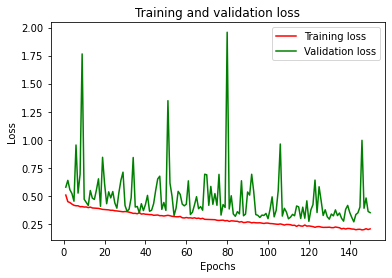

In [ ]:
#Print the loss history & save the plot
print_loss_history(m_history, modelname, expno)

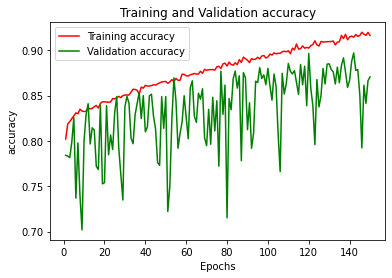

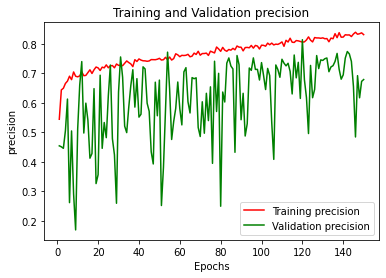

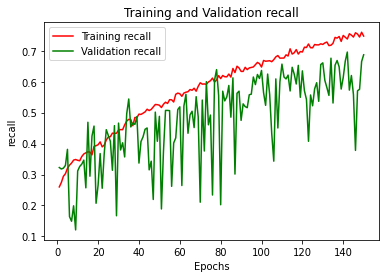

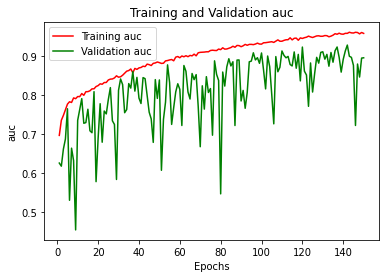

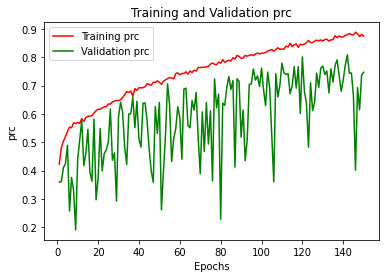

In [ ]:
#Print the macro-stats & save the plots
mets = ['accuracy', 'precision', 'recall', 'auc', 'prc']
print_training_history(m_history, mets, modelname, expno)

#Metric Time!!
For this project, there are seven labels which may be applied to any given image, with the only constraint being that the last one (index 6 indicating 'Normal') cannot be set to one if any others are also set to one. The standard metrics are Accuracy, Precision, Recall, and F1 Score, each of which has it's strengths and weaknesses.  
TP: True Positive 
TN: True Negative
FP: False Positive
FN: False Negative
#Accuracy = (TP + TN)/(TP + TN + FP + FN)
#Precision = TP/(TP + FP)
#Recall = TP/(TP + FN)
#F1 = (2PR)/(P + R)
Generally, for a medical test looking for a disease-state (indices 0 - 5 inclusive in this case), False Negatives are considered to be much worse than False Positives, because a person is being given a clean bill of health when in reality they have the disease condition, as such they are unlikely to get appropriate treatment as quickly.  Therefore *Recall* is generally more important than Accuracy or Precision for tests looking for a disease-state.  
In contrast, index 6 corresponds to a test for a healthy-state, so the roles are reversed: a False Positive means "clean bill of health when actually ill" and False Negative means "told one is ill when one is actually fine", therefore Precision is the more important metric.
Choosing an appropriate metric is complicated by the fact that there are six distinct disease states and only one healthy state, so a simple addition of the disease-state Recalls and the healthy-state Precision potentially ignores the case where a person has a disease but the algorithm isn't sure which.  This can be somewhat ameliorated by weighting Precision for healthy-state higher than the Recalls for the disease states, which is the approach taken here.  To really do this properly, one should consult with opthamologists to devise a single overall metric to judge by.

## Macro Metrics
We can get the macro-metrics directly from the Keras training history.  These are calculated using all seven states collectively, which means they aren't super useful beyond a simple "bigger is better" scheme.

In [ ]:
# Load in a trained model if not doing a specific training run
modelname = 'Model_Three'
expno = 6

model = tf.keras.models.load_model(f'{modelname}_expnum_{expno}')

## Micro Metrics
This is what we are actually concerned with, the ability of the model to effectively classify each individual ailment or to declare the patient ailment-free.

In [ ]:
#Create the multi-label confusion matrix
M_predictions = model.predict(X_val)
M_predictions_hard = np.round_(M_predictions)

M_MLCM = MLCM(y_val, M_predictions_hard)

In [ ]:
#Arguably the most important metric: how many inconsistencies?
inconsistencies = [idx for idx,pred in enumerate(M_predictions_hard) if sum(pred) > 1 and pred[-1] == 1]
print(f'Number of Inconsistencies: {len(inconsistencies)}')
print(f'Fraction of Inconsistencies: {len(inconsistencies)/len(M_predictions_hard)}')

Number of Inconsistencies: 1
Fraction of Inconsistencies: 0.0009699321047526673


We will now compute all of the usual metrics for each disease-state and the healthy-state.

In [ ]:
overall_accuracies, overall_precisions, overall_recalls, overall_f1s = substats(index_map, M_MLCM)

|--------------------Opacity----------------------|
Accuracy: 0.7837051406401552
Precision: 0.7240740740740741
Recall: 0.8408602150537634
F1 score: 0.7781094527363184
|--------------------Diabetic Retinopathy----------------------|
Accuracy: 0.8118331716779825
Precision: 0.5620915032679739
Recall: 0.7413793103448276
F1 score: 0.6394052044609666
|--------------------Glaucoma----------------------|
Accuracy: 0.903976721629486
Precision: 0.8225806451612904
Recall: 0.5698324022346368
F1 score: 0.6732673267326733
|--------------------Macular Edema----------------------|
Accuracy: 0.8525703200775946
Precision: 0.4391891891891892
Recall: 0.48507462686567165
F1 score: 0.4609929078014185
|--------------------Macular Degeneration----------------------|
Accuracy: 0.8709990300678953
Precision: 0.6176470588235294
Recall: 0.6961325966850829
F1 score: 0.6545454545454545
|--------------------Retinal Vascular Occlusion----------------------|
Accuracy: 0.9136760426770126
Precision: 0.8648648648648649
Re

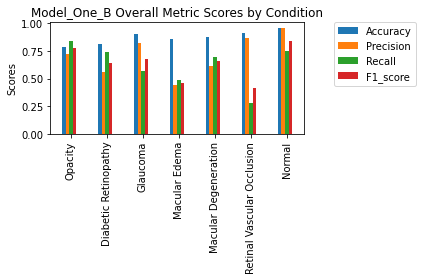

In [ ]:
plot_stats(f'{modelname} Overall', overall_accuracies, overall_precisions, overall_recalls, overall_f1s)

In [ ]:
#This cell is ALMOST redundant, need to figure out how we want to handle putting the metrics into the JSON file

#Recall the index ordering: 0 - Opacity, 1 - Diabetic Retinopathy, 2 - Glaucoma, 3 - Macular Edema,
# 4 - Macular Degeneration,  5 - Retinal Vascular Occlusion, 6 - Normal

overall_score = 0 #A perfect score, indicating perfect Recall on all disease states and perfect Precision for the healthy state, would be 12
metrics = {}

for i, cm in enumerate(M_MLCM):
    if i < 6:
        overall_score += recall_from_CM(cm)
    else:
        overall_score += 6 * precision_from_CM(cm)
    print('|---------------- %s -------------------|' % index_map[i])
    acc = accuracy_from_CM(cm)
    prec = precision_from_CM(cm)
    recall = recall_from_CM(cm)
    F1 = F1_from_CM(cm)
    submet = {}
    submet['Accuracy'] = acc
    submet['Precision'] = prec
    submet['Recall'] = recall
    submet['F1_score'] = F1
    metrics[index_map[i]] = submet
    print(f'Accuracy: {acc}')
    print(f'Precision: {prec}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {F1}')

print('+++++++++++++++++++++++++++++++++++++')
print('Overall score: ', overall_score)

|---------------- Opacity -------------------|
Accuracy: 0.7837051406401552
Precision: 0.7240740740740741
Recall: 0.8408602150537634
F1 Score: 0.7781094527363184
|---------------- Diabetic Retinopathy -------------------|
Accuracy: 0.8118331716779825
Precision: 0.5620915032679739
Recall: 0.7413793103448276
F1 Score: 0.6394052044609666
|---------------- Glaucoma -------------------|
Accuracy: 0.903976721629486
Precision: 0.8225806451612904
Recall: 0.5698324022346368
F1 Score: 0.6732673267326733
|---------------- Macular Edema -------------------|
Accuracy: 0.8525703200775946
Precision: 0.4391891891891892
Recall: 0.48507462686567165
F1 Score: 0.4609929078014185
|---------------- Macular Degeneration -------------------|
Accuracy: 0.8709990300678953
Precision: 0.6176470588235294
Recall: 0.6961325966850829
F1 Score: 0.6545454545454545
|---------------- Retinal Vascular Occlusion -------------------|
Accuracy: 0.9136760426770126
Precision: 0.8648648648648649
Recall: 0.27586206896551724
F1 S

In [ ]:
#Summary data, goes in JSON file for experiment tracking
expdata = {'Exp. No. ': expno, 'Model Name': modelname, 'Model Location': savelocation,'Hyperparameters': hypers, 
           'Training Time': delta_time, 'Metrics': metrics}
write_json(expdata)

updating JSON file


In [ ]:
#EXPERIMENTAL CELL, NOT FULLY OPERATIONAL
#Summary data, goes in JSON file for experiment tracking

#In reality the continue_experiment line would be much earlier, this is just showing where things come from
old_epochs, old_time, hypers, saveloc = continue_experiment(modelname, expno)
#Run experiment here for EPOCHS training epochs, which will take delta_time wall-clock time
total_time = old_time + delta_time
total_epochs = old_epochs + EPOCHS
expdata = {'Model Location': savelocation, 'Hyperparameters': hypers, 'Epochs': total_epochs, 'Training Time': total_time,
           'loss_function': loss_name, 'Metrics': metrics}
record_experiment(modelname, expno, expdata)

In [ ]:
#Stratified Metrics: How well does the model work on specific subsets of the validation set?
single_idxs = [idx for idx, p in enumerate(y_val) if sum(p) == 1] #Healthy or single ailment
double_idxs = [idx for idx, p in enumerate(y_val) if sum(p) == 2] #Two ailments
triple_idxs = [idx for idx, p in enumerate(y_val) if sum(p) == 3] #Three ailments
quad_idxs   = [idx for idx, p in enumerate(y_val) if sum(p) == 4] #Four ailments

print(f'Number of Singles in Val set: {len(single_idxs)}')
print(f'Number of Doubles in Val set: {len(double_idxs)}')
print(f'Number of Triples in Val set: {len(triple_idxs)}')
print(f'Number of Quads in Val set: {len(quad_idxs)}')

X_singles = np.array([X_val[idx] for idx in single_idxs])
y_singles = np.array([y_val[idx] for idx in single_idxs])
X_doubles = np.array([X_val[idx] for idx in double_idxs])
y_doubles = np.array([y_val[idx] for idx in double_idxs])
X_triples = np.array([X_val[idx] for idx in triple_idxs])
y_triples = np.array([y_val[idx] for idx in triple_idxs])
X_quads   = np.array([X_val[idx] for idx in quad_idxs])
y_quads   = np.array([y_val[idx] for idx in quad_idxs])

print(f'Shape of X_singles: {X_singles.shape}')

Number of Singles in Val set: 679
Number of Doubles in Val set: 277
Number of Triples in Val set: 70
Number of Quads in Val set: 5
Shape of X_singles: (679, 224, 224, 3)


In [ ]:
M_pred_singles = np.round_(model.predict(X_singles))
M_MLCM_singles = MLCM(y_singles, M_pred_singles)

In [ ]:
single_accuracies, single_precisions, single_recalls, single_f1s = substats(index_map, M_MLCM_singles)

|--------------------Opacity----------------------|
Accuracy: 0.8026509572901326
Precision: 0.6166134185303515
Recall: 0.9323671497584541
F1 score: 0.7423076923076923
|--------------------Diabetic Retinopathy----------------------|
Accuracy: 0.8232695139911634
Precision: 0.3178294573643411
Recall: 0.5616438356164384
F1 score: 0.4059405940594059
|--------------------Glaucoma----------------------|
Accuracy: 0.9189985272459499
Precision: 0.782051282051282
Recall: 0.6161616161616161
F1 score: 0.6892655367231638
|--------------------Macular Edema----------------------|
Accuracy: 0.9263622974963182
Precision: 0.06382978723404255
Recall: 0.3333333333333333
F1 score: 0.10714285714285714
|--------------------Macular Degeneration----------------------|
Accuracy: 0.8954344624447718
Precision: 0.5748031496062992
Recall: 0.8111111111111111
F1 score: 0.6728110599078341
|--------------------Retinal Vascular Occlusion----------------------|
Accuracy: 0.9499263622974963
Precision: 0.7894736842105263
R

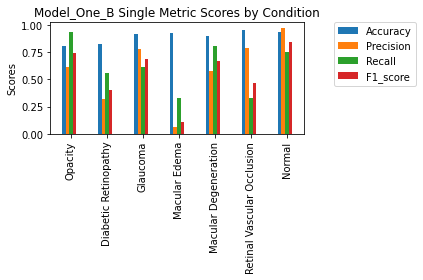

In [ ]:
plot_stats(f'{modelname} Single', single_accuracies, single_precisions, single_recalls, single_f1s)

In [ ]:
M_pred_doubles = np.round_(model.predict(X_doubles))
M_MLCM_doubles = MLCM(y_doubles, M_pred_doubles)

In [ ]:
double_accuracies, double_precisions, double_recalls, double_f1s = substats(index_map, M_MLCM_doubles)

|--------------------Opacity----------------------|
Accuracy: 0.7545126353790613
Precision: 0.8457142857142858
Recall: 0.783068783068783
F1 score: 0.8131868131868131
|--------------------Diabetic Retinopathy----------------------|
Accuracy: 0.779783393501805
Precision: 0.7016129032258065
Recall: 0.7837837837837838
F1 score: 0.7404255319148936
|--------------------Glaucoma----------------------|
Accuracy: 0.8736462093862816
Precision: 0.8717948717948718
Recall: 0.53125
F1 score: 0.6601941747572816
|--------------------Macular Edema----------------------|
Accuracy: 0.7509025270758123
Precision: 0.463768115942029
Recall: 0.5
F1 score: 0.48120300751879697
|--------------------Macular Degeneration----------------------|
Accuracy: 0.8303249097472925
Precision: 0.7846153846153846
Recall: 0.6071428571428571
F1 score: 0.6845637583892618
|--------------------Retinal Vascular Occlusion----------------------|
Accuracy: 0.8916967509025271
Precision: 0.9285714285714286
Recall: 0.30952380952380953
F1

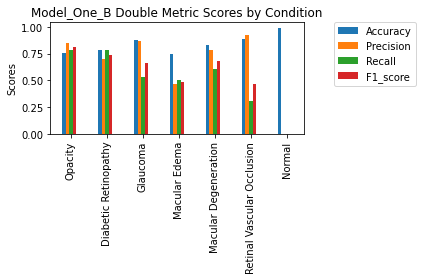

In [ ]:
plot_stats(f'{modelname} Double', double_accuracies, double_precisions, double_recalls, double_f1s)

In [ ]:
M_pred_triples = np.round_(model.predict(X_triples))
M_MLCM_triples = MLCM(y_triples, M_pred_triples)

In [ ]:
triple_accuracies, triple_precisions, triple_recalls, triple_f1s = substats(index_map, M_MLCM_triples)

|--------------------Opacity----------------------|
Accuracy: 0.7428571428571429
Precision: 0.96
Recall: 0.75
F1 score: 0.8421052631578947
|--------------------Diabetic Retinopathy----------------------|
Accuracy: 0.8285714285714286
Precision: 0.84
Recall: 0.9130434782608695
F1 score: 0.8749999999999999
|--------------------Glaucoma----------------------|
Accuracy: 0.9
Precision: 1.0
Recall: 0.46153846153846156
F1 score: 0.631578947368421
|--------------------Macular Edema----------------------|
Accuracy: 0.5571428571428572
Precision: 0.9310344827586207
Recall: 0.48214285714285715
F1 score: 0.6352941176470589
|--------------------Macular Degeneration----------------------|
Accuracy: 0.8
Precision: 0.18181818181818182
Recall: 0.2857142857142857
F1 score: 0.2222222222222222
|--------------------Retinal Vascular Occlusion----------------------|
Accuracy: 0.7142857142857143
Precision: 1.0
Recall: 0.16666666666666666
F1 score: 0.2857142857142857
|--------------------Normal------------------

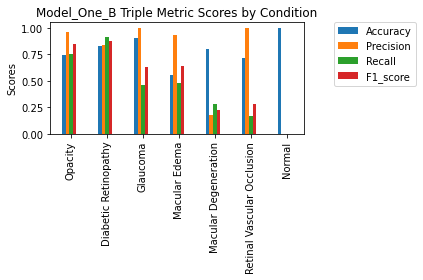

In [ ]:
plot_stats(f'{modelname} Triple', triple_accuracies, triple_precisions, triple_recalls, triple_f1s)

In [ ]:
M_pred_quads = np.round_(model.predict(X_quads))
M_MLCM_quads = MLCM(y_quads, M_pred_quads)

In [ ]:
quad_accuracies, quad_precisions, quad_recalls, quad_f1s = substats(index_map, M_MLCM_quads)

|--------------------Opacity----------------------|
Accuracy: 0.4
Precision: 1.0
Recall: 0.4
F1 score: 0.5714285714285715
|--------------------Diabetic Retinopathy----------------------|
Accuracy: 0.8
Precision: 0.6666666666666666
Recall: 1.0
F1 score: 0.8
|--------------------Glaucoma----------------------|
Accuracy: 0.6
Precision: 1.0
Recall: 0.3333333333333333
F1 score: 0.5
|--------------------Macular Edema----------------------|
Accuracy: 0.6
Precision: 1.0
Recall: 0.6
F1 score: 0.7499999999999999
|--------------------Macular Degeneration----------------------|
Accuracy: 0.8
Precision: 0
Recall: 0
F1 score: 0
|--------------------Retinal Vascular Occlusion----------------------|
Accuracy: 0
Precision: 0
Recall: 0
F1 score: 0
|--------------------Normal----------------------|
Accuracy: 1.0
Precision: 0
Recall: 0
F1 score: 0


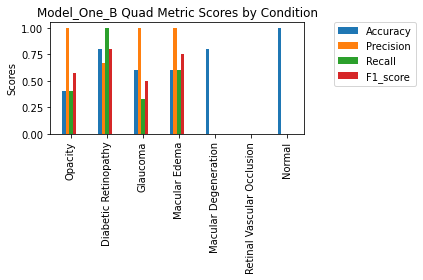

In [ ]:
plot_stats(f'{modelname} Quad', quad_accuracies, quad_precisions, quad_recalls, quad_f1s)

## Barrier Cell

In [ ]:
#Use this to get the name of the last residual layer for the heatmap step later
model.summary()

## Explainability
A major criticism of deep learning systems is that they often act as a black box, churning out answers without any apparent rhyme or reason, which can be quite dangerous if the model is not perfect. 

One way to get under the hood of a visual DL model is to look at the  activations of each layer on known inputs.

In [ ]:
# Use a list comprehension to extract the output of each layer in the model
layer_outputs = [layer.output for layer in model.layers]

# Define a new model with the same input shape as the original model 
# and layer_outputs as its outputs
activation_model = Model(inputs=model.inputs, outputs=layer_outputs)

# Get all the activations by calling the predict() method on the target image 
# in X_train. Make sure to reshape the image so it has a new 0 axis of length 1.

We must identify images in the training set for each category in isolation.  We know from before that all categories appear many times, but we only need the one example for each, no need to get carried away.

In [ ]:
M_predictions = model.predict(X_val)
M_pred_hard = np.round_(M_predictions)

In [ ]:
#Opacity only                    --> (1,0,0,0,0,0,0)
#Diabetic Retinopathy only       --> (0,1,0,0,0,0,0)
#Glaucoma only                   --> (0,0,1,0,0,0,0)
#Macular Edema only              --> (0,0,0,1,0,0,0)
#Macular Degeneration only       --> (0,0,0,0,1,0,0)
#Retinal Vascular Occlusion only --> (0,0,0,0,0,1,0)
#Normal                          --> (0,0,0,0,0,0,1)

Opacity_indices  = [idx for idx,pred in enumerate(M_pred_hard) if np.all(pred == y_val[idx]) and np.all(pred == (1,0,0,0,0,0,0))]
DR_indices       = [idx for idx,pred in enumerate(M_pred_hard) if np.all(pred == y_val[idx]) and np.all(pred == (0,1,0,0,0,0,0))]
Glaucoma_indices = [idx for idx,pred in enumerate(M_pred_hard) if np.all(pred == y_val[idx]) and np.all(pred == (0,0,1,0,0,0,0))]
MacEd_indices    = [idx for idx,pred in enumerate(M_pred_hard) if np.all(pred == y_val[idx]) and np.all(pred == (0,0,0,1,0,0,0))]
MacDeg_indices   = [idx for idx,pred in enumerate(M_pred_hard) if np.all(pred == y_val[idx]) and np.all(pred == (0,0,0,0,1,0,0))]
RVO_indices      = [idx for idx,pred in enumerate(M_pred_hard) if np.all(pred == y_val[idx]) and np.all(pred == (0,0,0,0,0,1,0))]
Normal_indices   = [idx for idx,pred in enumerate(M_pred_hard) if np.all(pred == y_val[idx]) and np.all(pred == (0,0,0,0,0,0,1))]


print(f'Number of correct Opacity predictions: {len(Opacity_indices)}')
print(f'Number of correct DR predictions: {len(DR_indices)}')
print(f'Number of correct Glaucoma predictions: {len(Glaucoma_indices)}')
print(f'Number of correct MacEd predictions: {len(MacEd_indices)}')
print(f'Number of correct MacDeg predictions: {len(MacDeg_indices)}')
print(f'Number of correct RVO predictions: {len(RVO_indices)}')
print(f'Number of correct Normal predictions: {len(Normal_indices)}')

Number of correct Opacity predictions: 132
Number of correct DR predictions: 18
Number of correct Glaucoma predictions: 54
Number of correct MacEd predictions: 0
Number of correct MacDeg predictions: 65
Number of correct RVO predictions: 22
Number of correct Normal predictions: 124


In [ ]:
#Run this for Model One only, hard-code the indices for the other two later
#Deal with MacEd separately
Opacity_idx = Opacity_indices[0]
DR_idx = DR_indices[0]
Glauc_idx = Glaucoma_indices[0]
MacDeg_idx = MacDeg_indices[0]
RVO_idx = RVO_indices[0]
Normal_idx = Normal_indices[0]

print(f'Opacity index: {Opacity_idx}')
print(f'DR index: {DR_idx}')
print(f'Glaucoma index: {Glauc_idx}')
print(f'MacDeg index: {MacDeg_idx}')
print(f'RVO index: {RVO_idx}')
print(f'Normal index: {Normal_idx}')

Opacity index: 0
DR index: 24
Glaucoma index: 23
MacDeg index: 18
RVO index: 12
Normal index: 15


In [ ]:
Opacity_idx = 0
DR_idx = 24
Glauc_idx = 23
MacDeg_idx = 18
RVO_idx = 12
Normal_idx = 15

print(f'|---------------{modelname}----------------|')
print(f'Opacity probability: {M_predictions[Opacity_idx][0]}')
print(f'DR probability: {M_predictions[DR_idx][1]}')
print(f'Glaucoma probability: {M_predictions[Glauc_idx][2]}')
print(f'MacDeg probability: {M_predictions[MacDeg_idx][4]}')
print(f'RVO probability: {M_predictions[RVO_idx][5]}')
print(f'Normal probability: {M_predictions[Normal_idx][6]}')

|---------------Model_Three----------------|
Opacity probability: 0.9129446148872375
DR probability: 0.9263263940811157
Glaucoma probability: 0.7817981839179993
MacDeg probability: 0.9933271408081055
RVO probability: 0.06906282156705856
Normal probability: 0.999974250793457


Let's make use of the grad-CAM functions found here: https://keras.io/examples/vision/grad_cam/

These will allow us to visualize the output of the last convolutional layer of the model & possibly overlay it on the original image.

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img, heatmap, org_path: str='original.jpg', cam_path: str="cam.jpg", alpha: float=0.4):
    # Load the original image
    #img = keras.preprocessing.image.load_img(img_path)
    #img = keras.preprocessing.image.img_to_array(img)
    # Rescale image to a range 0 - 255
    img = np.uint(255 * img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = colormap.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save original image with recognizable name
    original_img = tf.keras.preprocessing.image.array_to_img(img) #Not sure if necessary...
    #original_img.save(org_path)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, None, None, 64)    9472      
                                                                 
 batch_normalization_41 (Bat  (None, None, None, 64)   256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, None, None, 64)    0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 64)   0         
 2D)                                                             
                                                                 
 general_resnet_block_5 (Gen  (None, 56, 56, 64)       297472    
 eralResnetBlock)                                                
                                                      

In [ ]:
##Test cell, checking whether the tf.keras.preprocessing line is needed for the original image
last_conv_name = 'general_resnet_block_3'
idx = 0
image = X_val[idx]
img_array = np.expand_dims(image, axis=0)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_name)
save_and_display_gradcam(image, heatmap, f'{MAIN_DIR}/TEST_original_img.jpg', f'{MAIN_DIR}/TEST_overlay_img.jpg')

In [ ]:
#Generify the content of the next few cells
last_conv_name = 'general_resnet_block_9' #Must find a better way to grab this...

#names = ['Opacity', 'DiabeticRetinopathy', 'Glaucoma', 'MacularEdema', 'MacularDegeneration', 'RetinalVascularOcclusion', 'Normal']
#indices = [Opacity_idx, DR_idx, Glauc_idx, MacEd_idx, MacDeg_idx, RVO_idx, Normal_idx]
names = ['Opacity', 'DiabeticRetinopathy', 'Glaucoma', 'MacularDegeneration', 'RetinalVascularOcclusion', 'Normal']
indices = [Opacity_idx, DR_idx, Glauc_idx, MacDeg_idx, RVO_idx, Normal_idx]
images = [X_val[idx] for idx in indices]
img_arrays = [np.expand_dims(image, axis=0) for image in images]
heatmaps = [make_gradcam_heatmap(img_array, model, last_conv_name) for img_array in img_arrays]

In [ ]:
for image,heatmap,name in zip(images, heatmaps, names):
    orgname = f'{MAIN_DIR}/{modelname}_expnum_{expno}_{name}_original.jpg'
    save_and_display_gradcam(image, heatmap, orgname,f'{MAIN_DIR}/{modelname}_expnum_{expno}_{name}_overlay.jpg')

## Barrier Cell
Several of these are probably superfluous & will be deleted soon

In [ ]:
#IDK if we actually need these for anything...
#indices = [Opacity_idx, DR_idx, Glauc_idx, MacEd_idx, MacDeg_idx, RVO_idx, Normal_idx]
#for idx, x in enumerate(indices):
#    activations = activation_model.predict(X_val[x].reshape(1,224,224,3))
#    display_activation(activations=activations, condition=index_map[idx], col_size=8, row_size=8, act_index=1)

## Barrier cell
Probably don't need the next few, I believe the two above completely cover them.